In [2]:
from pathlib import Path
import pickle
import pandas as pd

data_folder = Path.home() / 'Documents' / 'TFG' / 'data'

with open(data_folder / 'dataset_info.pkl', "rb") as f:
	dataset_info = pickle.load(f)

df = dataset_info['df']

print(df)

           image_id     dx
0      ISIC_0027419    bkl
1      ISIC_0025030    bkl
2      ISIC_0026769    bkl
3      ISIC_0025661    bkl
4      ISIC_0031633    bkl
...             ...    ...
10010  ISIC_0033084  akiec
10011  ISIC_0033550  akiec
10012  ISIC_0033536  akiec
10013  ISIC_0032854  akiec
10014  ISIC_0032258    mel

[10015 rows x 2 columns]


In [ ]:
# Settings

source_folder = data_folder / 'ham10000'
images_folder = source_folder / 'images'
masks_folder = source_folder / 'semantic_segmentations'


destination_folder = data_folder / 'sl'
destination_folder.mkdir(exist_ok=True)
destination_images_folder = destination_folder / 'images'
destination_images_folder.mkdir(exist_ok=True)
destination_masks_folder = destination_folder / 'masks'
destination_masks_folder.mkdir(exist_ok=True)


target_height = 192
target_width = 256
original_height = 450
original_width = 600
background = 0


def get_new_borders(new_size, start, end, original_size):
	size = end - start
	start = start - (new_size - size) // 2
	end = start + new_size
	if start < 0:
		end = end - start
		start = 0
	if end > original_size:
		start = start - (end - original_size)
		end = original_size
	return new_size, start, end

In [ ]:
from tqdm import tqdm
from PIL import Image
import numpy as np

print("Preprocessant les imatges i màscares:")
for _, row in tqdm(df.iterrows(), total=len(df)):
	
	image_id = row['image_id']

	try:
		mask_file = masks_folder / f'{image_id}.png'
		mask_pil = Image.open(mask_file).convert('L')
		mask_array = np.array(mask_pil)

		image_file = images_folder / f'{image_id}.jpg'
		image_pil = Image.open(image_file).convert('RGB')
		image_array = np.array(image_pil)
		
		# Es busquen les coordenades que encaixen la lesió
		nonzero_coords = np.argwhere(mask_array > background)
		top, left = nonzero_coords.min(axis=0)
		bottom, right = nonzero_coords.max(axis=0) + 1  # S'inclou en la caixa
		
		width = right - left
		height = bottom - top

		if(width != original_width and height != original_height):
			if(width < target_width):
				width, left, right = get_new_borders(target_width, left, right, original_width)

			if(height < target_height):
				height, top, bottom = get_new_borders(target_height, top, bottom, original_height)			

			if(width > target_width):
				if((width - target_width) % 4):
					new_width = width + 4 - ((width - target_width) % 4)
					width, left, right = get_new_borders(new_width, left, right, original_width)

			if(height > target_height):
				if((height - target_height) % 3):
					new_height = height + 3 - ((height - target_height) % 3)
					height, top, bottom = get_new_borders(new_height, top, bottom, original_height)

			ratio = height / width
			if(ratio > 0.75):
				new_width = int(height / 0.75)
				width, left, right = get_new_borders(new_width, left, right, original_width)
			elif(ratio < 0.75):
				new_height = int(width * 0.75)
				height, top, bottom = get_new_borders(new_height, top, bottom, original_height)

			mask_pil = mask_pil.crop((left, top, right, bottom))
			image_pil = image_pil.crop((left, top, right, bottom))
		
		if (height > target_height):
			mask_pil = mask_pil.resize((target_width, target_height), Image.NEAREST)
			image_pil = image_pil.resize((target_width, target_height), Image.BICUBIC)
		
		# save image and mask to prepocessed folder
		destination_mask_file = destination_masks_folder / f'{image_id}.png'
		mask_pil.save(destination_mask_file)
		
		destination_image_file = destination_images_folder / f'{image_id}.jpg'
		image_pil.save(destination_image_file)
    
	except Exception as e:
		print(f"Error amb {image_id}: {e}")


Preprocessant les imatges i màscares:


100%|██████████| 10015/10015 [05:16<00:00, 31.60it/s]


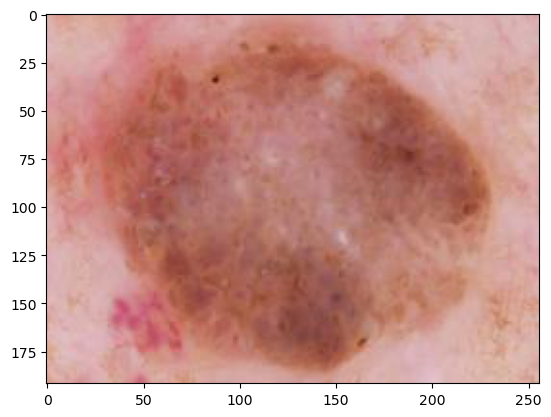

In [60]:
# Es visualitza una imatge aleatòria i la seva màscara
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

row = df.sample().iloc[0]
image_id = row['image_id']
dx = row['dx']

try:
	mask_path = destination_masks_folder / f'{image_id}.png'
	mask_image = Image.open(mask_path).convert('L')

	image_path = destination_images_folder / f'{image_id}.jpg'
	image = Image.open(image_path).convert('RGB')
	plt.imshow(image)

except Exception as e:
	print(f"No se pudo procesar la imagen {image_id}: {e}")

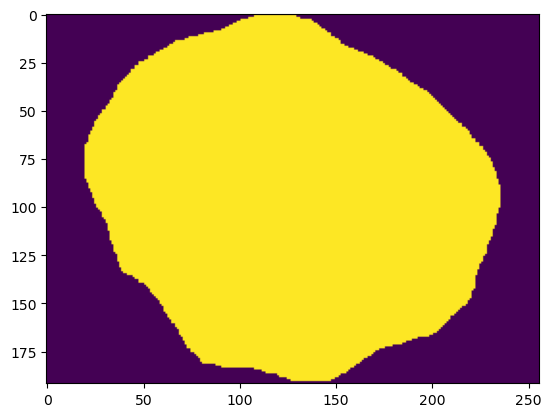

In [61]:
plt.imshow(mask_image)